- purpose：可视化卷积过程中的某一层
- time:20190627
- author: andyni

## 加载keras模块

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from keras.applications import vgg16
from keras import backend as K

Using TensorFlow backend.


## 变量初始化

In [4]:
# 对于每个滤波器，生成图像的维度
img_width = 128
img_height = 128

# 想去可视化层的名字
# (看模型定义在 keras/applications/vgg16.py)
layer_name = 'block5_conv1'

### 工具类函数：将张量转换为有效图像

In [24]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)  # 边界确定函数

    # convert to RGB array
    """
    if "image_dim_ordering": is "th" and "backend": "theano", your input_shape must be (channels, height, width)
    if "image_dim_ordering": is "tf" and "backend": "tensorflow", your input_shape must be (height, width, channels)
    """
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
        
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [26]:
def normalize(x):
    # 效用函数通过其L2范数标准化张量
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

## 建立模型

### 调用预训练的VGG16模型

In [16]:
# 使用ImageNet的权重，构造VGG16网络
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('VGG16 Model loaded.')

VGG16 Model loaded.


### 打印模型

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [21]:
model.layers

### 为输入图像定义一个placeholder

In [18]:
input_img = model.input
input_img

<tf.Tensor 'input_3:0' shape=(?, ?, ?, 3) dtype=float32>

### 用一个字典layer_dict 存放每一层

In [23]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict.keys())

dict_keys(['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool'])


## 提取滤波器（卷积核）
通过梯度上升，修改输入图像，使得滤波器（vgg中对应层的卷积核）的激活最大化。

这时的输入图像就是我们要可视化的滤波器

In [29]:
kept_filters = []

for filter_index in range(0, 200):
    # 只扫描前200个（实际上有512个）滤波器（卷积核）
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # 构建一个损耗函数，使所考虑的层的第n个滤波器的激活最大化
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering() == 'th':
        loss = K.mean(layer_output[:, filter_index, :, :])  # channel在第二维
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])  # channel在第四维

    # 计算输入图像的梯度与这个损失
    grads = K.gradients(loss, input_img)[0]

    # 归一化技巧：规范化梯度
    grads = normalize(grads)

    # 此函数返回 给定输入图像 的loss和梯度
    iterate = K.function([input_img], [loss, grads])

    # 梯度上升的步长
    step = 1.

    # 从带有一些随机噪声的灰色图像开始
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # 运行梯度上升20步
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if i %10 == 0:
            print(filter_index, i, 'Current loss value:', loss_value)
        if loss_value <= 0.:
            # 一些过滤器陷入0，我们可以跳过它们
            break
            
     # 解码所得到的输入图像
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time), '\n', '--'*30)

Processing filter 0
0 0 Current loss value: 12.179126
0 10 Current loss value: 223.22285
Filter 0 processed in 5s ------------------------------------------------------------
Processing filter 1
1 0 Current loss value: 0.01848275
1 10 Current loss value: 323.25006
Filter 1 processed in 5s ------------------------------------------------------------
Processing filter 2
2 0 Current loss value: 8.717914
2 10 Current loss value: 329.6714
Filter 2 processed in 5s ------------------------------------------------------------
Processing filter 3
3 0 Current loss value: 11.583638
3 10 Current loss value: 639.3717
Filter 3 processed in 5s ------------------------------------------------------------
Processing filter 4
4 0 Current loss value: 9.903736
4 10 Current loss value: 474.16144
Filter 4 processed in 5s ------------------------------------------------------------
Processing filter 5
5 0 Current loss value: 25.031078
5 10 Current loss value: 393.9411
Filter 5 processed in 5s ---------------

48 10 Current loss value: 749.2689
Filter 48 processed in 5s ------------------------------------------------------------
Processing filter 49
49 0 Current loss value: 1.8533581
49 10 Current loss value: 647.7013
Filter 49 processed in 5s ------------------------------------------------------------
Processing filter 50
50 0 Current loss value: 2.3630152
50 10 Current loss value: 147.88004
Filter 50 processed in 5s ------------------------------------------------------------
Processing filter 51
51 0 Current loss value: 0.1909488
51 10 Current loss value: 487.66037
Filter 51 processed in 5s ------------------------------------------------------------
Processing filter 52
52 0 Current loss value: 0.0
Filter 52 processed in 0s ------------------------------------------------------------
Processing filter 53
53 0 Current loss value: 73.025986
53 10 Current loss value: 885.5332
Filter 53 processed in 5s ------------------------------------------------------------
Processing filter 54
54 0 C

99 0 Current loss value: 0.048002142
99 10 Current loss value: 158.96886
Filter 99 processed in 5s ------------------------------------------------------------
Processing filter 100
100 0 Current loss value: 0.0
Filter 100 processed in 0s ------------------------------------------------------------
Processing filter 101
101 0 Current loss value: 0.78304946
101 10 Current loss value: 313.63562
Filter 101 processed in 5s ------------------------------------------------------------
Processing filter 102
102 0 Current loss value: 0.0
Filter 102 processed in 0s ------------------------------------------------------------
Processing filter 103
103 0 Current loss value: 1.5151124
103 10 Current loss value: 631.0695
Filter 103 processed in 5s ------------------------------------------------------------
Processing filter 104
104 0 Current loss value: 0.0
Filter 104 processed in 0s ------------------------------------------------------------
Processing filter 105
105 0 Current loss value: 0.0
Fi

147 10 Current loss value: 450.31686
Filter 147 processed in 6s ------------------------------------------------------------
Processing filter 148
148 0 Current loss value: 0.09374194
148 10 Current loss value: 146.69499
Filter 148 processed in 6s ------------------------------------------------------------
Processing filter 149
149 0 Current loss value: 76.85804
149 10 Current loss value: 630.75903
Filter 149 processed in 6s ------------------------------------------------------------
Processing filter 150
150 0 Current loss value: 22.661034
150 10 Current loss value: 464.01105
Filter 150 processed in 6s ------------------------------------------------------------
Processing filter 151
151 0 Current loss value: 0.9635317
151 10 Current loss value: 145.2435
Filter 151 processed in 6s ------------------------------------------------------------
Processing filter 152
152 0 Current loss value: 3.700871
152 10 Current loss value: 375.43384
Filter 152 processed in 6s -----------------------

195 0 Current loss value: 0.010271224
195 10 Current loss value: 208.21161
Filter 195 processed in 6s ------------------------------------------------------------
Processing filter 196
196 0 Current loss value: 0.0
Filter 196 processed in 1s ------------------------------------------------------------
Processing filter 197
197 0 Current loss value: 0.0
Filter 197 processed in 1s ------------------------------------------------------------
Processing filter 198
198 0 Current loss value: 0.0
Filter 198 processed in 1s ------------------------------------------------------------
Processing filter 199
199 0 Current loss value: 0.0
Filter 199 processed in 1s ------------------------------------------------------------


## 选择使用滤波器（卷积核）

In [30]:
# 将在8 x 8网格上选择最好的64个滤波器。
n = 8

# 具有最高损失的过滤器被假定为更好
# 只保留前64个过滤器
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

In [31]:
# 构建一张黑色的图片，有足够的空间
# 尺寸为128 x 128的8 x 8过滤器，中间有5px的边距

margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))  # 空白图片

In [32]:
# 使用保存的过滤器填充图片
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

In [36]:
print(img.shape)
print(stitched_filters.shape)

(128, 128, 3)
(1059, 1059, 3)


## 显示滤波器（卷积核）

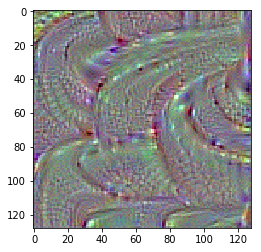

In [34]:
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


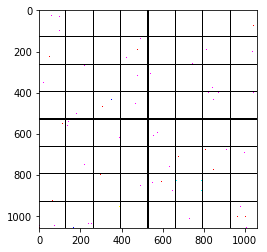

In [35]:
plt.imshow(stitched_filters)
plt.show()